In [1]:
!pip install joblib gdown

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/10s_-i2C9N9z0n4UM0DPgWGY7o72EIXqO/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1FuLwQSs5s-Rhr4kcPO-hAyVpZGeRT8Ny/view?usp=drive_link
!gdown --fuzzy https://drive.google.com/file/d/18yIglS77gmIb99JrL2S_bc621ubLC50C/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?id=10s_-i2C9N9z0n4UM0DPgWGY7o72EIXqO
To: /content/simulatedTwoTheta_20250215.pkl
100% 64.2k/64.2k [00:00<00:00, 64.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FuLwQSs5s-Rhr4kcPO-hAyVpZGeRT8Ny
To: /content/SP_phaseFractionList_40K_20250215.pkl
100% 760k/760k [00:00<00:00, 116MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=18yIglS77gmIb99JrL2S_bc621ubLC50C
From (redirected): https://drive.google.com/uc?id=18yIglS77gmIb99JrL2S_bc621ubLC50C&confirm=t&uuid=de642cc0-dab9-44be-ba5f-efe3c9ccb496
To: /content/XRD_patternList_40K_20250215.pkl
100% 2.56G/2.56G [00:34<00:00, 73.3MB/s]


rawX shape: (40002, 8000)
rawY shape: (40002,)
Train set: (32001, 8000) (32001,)
Val set:   (4000, 8000) (4000,)
Test set:  (4001, 8000) (4001,)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch [1/200], Train Loss: 9277981491.986582, Val Loss: 1176.973584


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/200], Train Loss: 716772.607486, Val Loss: 0.008664
Epoch [3/200], Train Loss: 0.008660, Val Loss: 0.008664
Epoch [4/200], Train Loss: 0.008693, Val Loss: 0.008663
Epoch [5/200], Train Loss: 0.008659, Val Loss: 0.008662
Epoch [6/200], Train Loss: 0.008681, Val Loss: 0.008661
Epoch [7/200], Train Loss: 0.008667, Val Loss: 0.008660
Epoch [8/200], Train Loss: 0.008679, Val Loss: 0.008658
Epoch [9/200], Train Loss: 0.008654, Val Loss: 0.008655
Epoch [10/200], Train Loss: 0.008695, Val Loss: 0.008652
Epoch [11/200], Train Loss: 0.008655, Val Loss: 0.008648
Epoch [12/200], Train Loss: 0.008650, Val Loss: 0.008643
Epoch [13/200], Train Loss: 0.008639, Val Loss: 0.008637
Epoch [14/200], Train Loss: 0.008632, Val Loss: 0.008628
Epoch [15/200], Train Loss: 0.008621, Val Loss: 0.008617
Epoch [16/200], Train Loss: 0.008618, Val Loss: 0.008604
Epoch [17/200], Train Loss: 0.008601, Val Loss: 0.008586
Epoch [18/200], Train Loss: 0.008633, Val Loss: 0.008564
Epoch [19/200], Train Loss: 0.0085

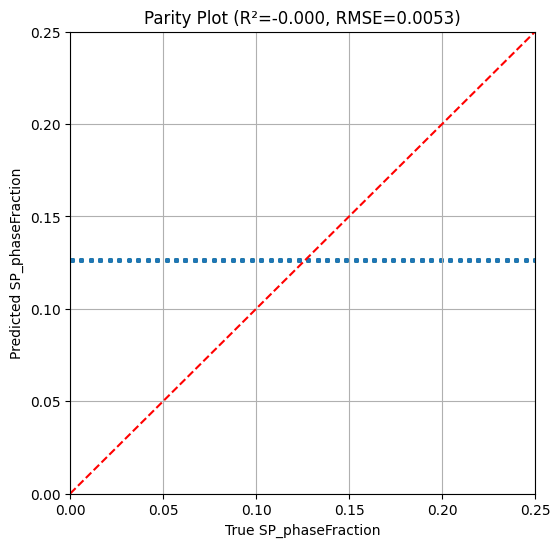

In [7]:
import os
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""
构建一个 Convolutional NN ，
	数据格式
		input 和 output 数据存储在 pkl 文件里，需要用 joblib 加载
			input = 【40002，8000】，

			output = 【40002，1】，数值范围 0 ~ 0.25
		存放的目录 NH55  D:\cs\git_prjs\XRD_multiPhase_ID_bigFiles CNN_predict_SPphaseFractionDataset
			simulatedTwoTheta_20250215.pkl np-array （8000， 0）XRD的 two theta
			ML-input: XRD_patternList_40K_20250215.pkl [40K, 8000]
			ML-output: SP_phaseFractionList_40K_20250215.pkl [40K, 1]

	CNN 架构
		可以 尝试 6 层 conv+max pooling layer

	CNN 训练后的 结果 用 R squares， RMSE 和 parity plot
"""

fd = '/content'

# SP_phaseFraction, [40002]
rawY_list = joblib.load(os.path.join(fd, 'SP_phaseFractionList_40K_20250215.pkl'))

# XRD_pattern=XRD-Intensity, [40002, (8000, )]
rawX = joblib.load(os.path.join(fd, 'XRD_patternList_40K_20250215.pkl'))

# 转为 numpy 数组，便于后续处理
rawX = np.array(rawX, dtype=np.float32)
rawY = np.array(rawY_list, dtype=np.float32)
print("rawX shape:", rawX.shape)
print("rawY shape:", rawY.shape)

# CNN
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(rawX, rawY, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train set:", X_train.shape, y_train.shape)
print("Val set:  ", X_val.shape, y_val.shape)
print("Test set: ", X_test.shape, y_test.shape)

class XRD_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # X shape: (8000,) -> reshape to (1, 8000)
        x_data = self.X[idx].reshape(1, -1)
        y_data = self.Y[idx]
        return x_data, y_data

# 构建 DataLoader
batch_size = 64

train_dataset = XRD_Dataset(X_train, y_train)
val_dataset   = XRD_Dataset(X_val,   y_val)
test_dataset  = XRD_Dataset(X_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


class CNN_1D(nn.Module):
	def __init__(self):
		super(CNN_1D, self).__init__()

		# in_channels=1, out_channels=16
		self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
		self.pool1 = nn.MaxPool1d(kernel_size=2)

		self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
		self.pool2 = nn.MaxPool1d(kernel_size=2)

		self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
		self.pool3 = nn.MaxPool1d(kernel_size=2)

		self.conv4 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
		self.pool4 = nn.MaxPool1d(kernel_size=2)

		self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
		self.pool5 = nn.MaxPool1d(kernel_size=2)

		self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
		self.pool6 = nn.MaxPool1d(kernel_size=2)

		# 经过6次池化后，序列长度缩小 2^6=64 倍，原本 8000/64=125
		# out_channels=256, seq_len=125 (大概)，则特征尺寸为 (256 * 125)

		# 全连接层
		self.fc1 = nn.Linear(256 * 125, 128)
		self.fc2 = nn.Linear(128, 1)  # 输出 1 个值

		self.relu = nn.ReLU()

	def forward(self, x):
		x = self.pool1(self.relu(self.conv1(x)))
		x = self.pool2(self.relu(self.conv2(x)))
		x = self.pool3(self.relu(self.conv3(x)))
		x = self.pool4(self.relu(self.conv4(x)))
		x = self.pool5(self.relu(self.conv5(x)))
		x = self.pool6(self.relu(self.conv6(x)))

		# flatten
		x = x.view(x.size(0), -1)

		x = self.relu(self.fc1(x))
		x = self.fc2(x)  # 最后一层不加激活，回归输出

		return x


model = CNN_1D().to(device)
model = torch.compile(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200  # 根据实际情况修改

for epoch in range(num_epochs):
	model.train()
	running_loss = 0.0

	for i, (inputs, targets) in enumerate(train_loader):
		inputs = inputs.to(device)
		targets = targets.to(device)

		optimizer.zero_grad()
		outputs = model(inputs)

		loss = criterion(outputs, targets)
		loss.backward()
		optimizer.step()

		running_loss += loss.item()

	# 验证集
	model.eval()
	val_loss = 0.0
	with torch.no_grad():
		for inputs_val, targets_val in val_loader:
			inputs_val = inputs_val.to(device)
			targets_val = targets_val.to(device)
			outputs_val = model(inputs_val)

			loss_val = criterion(outputs_val, targets_val)
			val_loss += loss_val.item()

	print(f"Epoch [{epoch + 1}/{num_epochs}], "
		  f"Train Loss: {running_loss / len(train_loader):.6f}, "
		  f"Val Loss: {val_loss / len(val_loader):.6f}")

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
	for inputs_test, targets_test in test_loader:
		inputs_test = inputs_test.to(device)
		outputs_test = model(inputs_test)

		all_preds.append(outputs_test.cpu().numpy())
		all_targets.append(targets_test.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0).flatten()
all_targets = np.concatenate(all_targets, axis=0).flatten()

r2 = r2_score(all_targets, all_preds)
rmse = mean_squared_error(all_targets, all_preds)

print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.6f}")

plt.figure(figsize=(6,6))
plt.scatter(all_targets, all_preds, s=5, alpha=0.5)
plt.plot([0, 0.25], [0, 0.25], 'r--')  # 如果范围是 0~0.25，可画对角线
plt.xlabel("True SP_phaseFraction")
plt.ylabel("Predicted SP_phaseFraction")
plt.title(f"Parity Plot (R²={r2:.3f}, RMSE={rmse:.4f})")
plt.xlim([0, 0.25])
plt.ylim([0, 0.25])
plt.grid(True)
plt.show()